**Prerequisite**
1. Download LLama Model locally
  1. https://huggingface.co/TheBloke/Llama-2-13B-chat-GGUF/tree/main
2. Preload Sentence Transformer model (run the preload code below)

**Plan**

1. Use PDF document (e.g. a financial report)
2. Split using SentenceTransformer
3. Load to MongoDB
4. Search 
5. Add a prompt
6. Generate

In [1]:
import os
KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') != ''

In [2]:
# We will keep all global variables in an object to not pullute the global namespace.
class Object(object):
    pass

In [3]:
t = Object()

## Llama Config

In [4]:
# t.model_path = "../../data"
if KAGGLE:
    t.llm_path = "/kaggle/working/llama-2-13b-chat.Q6_K.gguf"
    t.layers = 50
else:    
#    t.model_path = "../../../data"
    t.model_path = "../../../../../data"
    t.llm_path = f"{t.model_path}/llama/llama-2-13b-chat.Q6_K.gguf"
    t.layers = 50

## Install Packages

In [5]:
if KAGGLE:
    !pip install langchain
    !pip install sentence-transformers
    !pip install "pymongo[srv]"
    !pip install typing-inspect==0.8.0 typing_extensions==4.5.0
    !pip install pypdf

In [6]:
if KAGGLE:
    !CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python==0.2.25 --force-reinstall --upgrade --no-cache-dir

In [7]:
if KAGGLE:
    !pip install -U numpy==1.24.1

## Pre-load Models

In [8]:
def preload():
    s = SentenceTransformersTokenTextSplitter()
    emb = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

## Imports

In [9]:
from pymongo import MongoClient
import os
from llama_cpp import Llama
from langchain_community.llms import LlamaCpp
import torch
import umap
from tqdm import tqdm
# https://www.sbert.net/docs/pretrained_models.html#model-overview
# Sentence BERT, based on BERT
from sentence_transformers import SentenceTransformer
# https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.RecursiveCharacterTextSplitter.ht
# https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.SentenceTransformersTokenTextSplitter.html
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter, 
    SentenceTransformersTokenTextSplitter
)
from pypdf import PdfReader
import ctypes
import matplotlib.pyplot as plt
import pickle
import numpy as np
from llama_cpp import llama_log_set
def my_log_callback(level, message, user_data):
    pass

log_callback = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_char_p, ctypes.c_void_p)(my_log_callback)
llama_log_set(log_callback, ctypes.c_void_p())

## MongoDB Config

In [10]:
if KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    t.uri = user_secrets.get_secret("MONGODB_URI")
else:
    t.uri = os.environ["MONGODB_URI"]
# Create a new client and connect to the server
t.client = MongoClient(t.uri)
# Send a ping to confirm a successful connection
try:
    t.client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [11]:
t.db = t.client.rag_llama
t.coll = t.db.mdb

In [12]:
if KAGGLE:
    !wget https://huggingface.co/TheBloke/Llama-2-13B-chat-GGUF/resolve/main/llama-2-13b-chat.Q6_K.gguf    
    preload()

## Load and Parse Documents

In [13]:
# t.reader = PdfReader("data/brk-2023-q3.pdf")
# t.reader = PdfReader("data/msft-2022.pdf")
if KAGGLE:
    t.reader = PdfReader(f"../input/mdb-pdf/{t.coll.name}-2022.pdf")
else:
    t.reader = PdfReader(f"data/{t.coll.name}-2022.pdf")
t.pages = [p.extract_text().strip() for p in t.reader.pages]

Pages are of various sizes. We need to split into chunks that fit into the model window, specifically, the BERT embedding 256-token sized window. 

So we'll join all pages, and use the SentenceTransformer splitter to split the doc into the chunks of the right size.

In [14]:
# print(t.pages[10])

In [15]:
t.ch_splitter =  RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1024,
    chunk_overlap=0
)
t.ch_chunks = t.ch_splitter.split_text("\n".join(t.pages))
len(t.ch_chunks)

573

In [16]:
t.token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=10, tokens_per_chunk=256)
t.token_chunks = []
for ch in t.ch_chunks:
    t.token_chunks.extend(t.token_splitter.split_text(ch))
len(t.token_chunks)

594

## Embedding Model

In [17]:
t.emb_model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [18]:
len(t.emb_model.encode(t.token_chunks[21]).tolist())

768

## Upload documents

In [19]:
len(list(t.coll.find().limit(10)))

10

In [20]:
# t.docs = []
# for t.ch in t.token_chunks:
#     t.doc = {
#         "text": t.ch,
#         "embedding": t.emb_model.encode(t.ch).tolist()
#     }
#     t.docs.append(t.doc)
#
# _ = t.coll.insert_many(t.docs)

In [21]:
len(list(t.coll.find().limit(10)))

10

## Query Index

Index definition:

```
{
  "fields": [
    {
      "type": "vector",
      "path": "emb",
      "numDimensions": 768,
      "similarity": "dotProduct"
    }
  ]
}
```

In [22]:
t.query = "What was the total revenue?"

t.results = t.coll.aggregate([{
    "$vectorSearch": {
        "queryVector": t.emb_model.encode(t.query).tolist(),
        "path": "embedding",
        "numCandidates": 100,
        "limit": 8,
        "index": f"{t.coll.name}_vector_index"
    }}])

t.context = "\n\n".join([d['text'] for d in t.results])

In [23]:
print(t.context[0:1000])

operations ( in thousands of u. s. dollars, except share and per share data ) years ended january 31, 2023 2022 2021 revenue : subscription $ 1, 235, 122 $ 842, 047 $ 565, 349 services 48, 918 31, 735 25, 031

the following table presents the company ’ s revenues disaggregated by primary geographical markets, subscription product categories and services ( in thousands ) : years ended january 31, 2023 2022 2021 primary geographical markets : americas $ 781, 763 $ 527, 081 $ 361, 351 emea 361, 566 257, 846 177, 448 asia pacific 140, 711 88, 855 51, 581 total $ 1, 284, 040 $ 873, 782 $ 590, 380 subscription product categories and services : mongodb atlas - related $ 808, 263 $ 492, 287 $ 270, 805 other subscription 426, 859 349, 760 294, 544 services 48, 918 31, 735 25, 031 total $ 1, 284, 040 $ 873, 782 $ 590, 380 customers located in the united states accounted for 55 %, 54 % and 56 % of total revenue for the years ended january 31, 2023, 2022 and 2021, respectively. customers located i

## Load LLama

In [24]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

# https://python.langchain.com/docs/guides/local_llms
t.llm = LlamaCpp(
    model_path=t.llm_path,
    n_gpu_layers=t.layers,
    n_threads=10, 
    n_ctx=4096, 
    n_batch=512,
    verbose=False,
    f16_kv=True,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3090, compute capability 8.6


## Query LLaMa

In [25]:
def ask(prompt, temp=0.8, top_p=0.95):
    out = t.llm.invoke(
        prompt, 
        max_tokens=512, 
        stop=["Q:"], 
        temperature=temp,
        top_p=top_p,
        top_k=10,
        repeat_penalty=1.2,
    )
    return out

Prompt Format:
```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_message }} [/INST]
```

### Query with RAG

In [26]:
def ask_with_context(question, context):
    full_prompt = (
    "<s>[INST]<<SYS>>\n"
    + "You are a helpful expert financial research assistant." 
    + "You answer questions about about information contained in a financial report."
    + "You will be given the user's question, and the relevant informaton from " 
    + "the financial report. Answer the question using only this information" 
    + "\n<</SYS>>\n\n"
    + "Information: {context}\n"
    + "Question: {question}\n"
    + "Answer:\n"
    + "[/INST]"
    )
    full_prompt = full_prompt.replace("{context}", context)
    full_prompt = full_prompt.replace("{question}", question)
    ask(full_prompt)

In [27]:
def find_context(question):
    results = t.coll.aggregate([{
    "$vectorSearch": {
        "queryVector": t.emb_model.encode(question).tolist(),
        "path": "embedding",
        "numCandidates": 200,
        "limit": 8,
        "index": f"{t.coll.name}_vector_index"
    }}])
    result_texts = [d['text'] for d in results]
    assert len(result_texts) > 0
    context = "\n\n".join(result_texts)
    return context

In [28]:
def ask_with_rag(question):
    context = find_context(question)
    ask_with_context(question, context)

In [29]:
%%time
ask_with_rag("What was the total revenue?")

  Based on the information provided in the financial report, the total revenue for the year ended January 31, 2023 was $1,284.0 million.CPU times: user 2.15 s, sys: 603 ms, total: 2.75 s
Wall time: 2.9 s


In [30]:
%%time
ask_with_rag("What was the operating income or loss?")

  Based on the information provided in the financial report, the operating income (loss) for the years ended January 31, 2023, 2022 and 2021 is as follows:

Year Ended January 31,
Operating Income (Loss):

2023 - $(346,655)
2022 - $(289,364)
2021 - $(209,304)CPU times: user 3.73 s, sys: 545 ms, total: 4.28 s
Wall time: 4.35 s


In [31]:
%%time
ask_with_rag("What was the operating income or loss in year 2022?")

  Based on the information provided, the operating income (loss) for the year ended January 31, 2022 was:

Operating loss: $(302,889)CPU times: user 2.04 s, sys: 393 ms, total: 2.44 s
Wall time: 2.56 s


In [32]:
%%time
ask_with_rag("Compare the total revenue between the years 2023 and 2022")

  Sure! Based on the information provided in the financial report, the total revenue for the year ended January 31, 2023 was $1,284.0 million, while the total revenue for the year ended January 31, 2022 was $873.8 million.

Therefore, there is a difference of $410.2 million between the two years, representing a 47% increase in total revenue from 2022 to 2023.CPU times: user 3.9 s, sys: 523 ms, total: 4.42 s
Wall time: 4.48 s


In [33]:
%%time
ask_with_rag("What time period does the report cover?")

  Based on the information provided, the report covers the fiscal year ended January 31, 2023.CPU times: user 1.37 s, sys: 281 ms, total: 1.66 s
Wall time: 1.79 s


In [34]:
%%time
ask_with_rag("Were there any changes to the executive team?")

  Based on the information provided in the financial report, there were no changes to the executive team during the period covered by the report. The signatures on the report indicate that the following individuals served as officers of the company as of March 17, 2023:

* Dev Ittycheria, President and Chief Executive Officer
* Michael Gordon, Chief Financial Officer
* Thomas Bull, Chief Accounting Officer
* Tom Killalea, Director
* Archana Agrawal, Director
* Roelof Botha, Director
* Hope Cochran, Director
* Francisco D'Souza, Director
* Charles M. Hazard Jr., DirectorCPU times: user 4.41 s, sys: 599 ms, total: 5.01 s
Wall time: 5.05 s


### Query Embedded Knowledge

In [35]:
def ask_llm(question):
    prompt = (
        f"<s>[INST]<<SYS>>\n"
        + f"You are a helpful expert financial research assistant." 
        + f"\n<</SYS>>\n\n"
        + f"Question: {question}\n"
        + f"Answer:\n"
        + f"[/INST]"
    )
    ask(prompt)

In [36]:
%%time
ask_llm("What was the total revenue of MongoDB in the year ended January 31, 2023?")

  As a helpful financial research assistant, I can provide you with the latest available financial information for MongoDB, Inc. (MDB). According to their annual report filed on Form 10-K with the Securities and Exchange Commission (SEC) for the fiscal year ended January 31, 2023, the total revenue of MongoDB was $854.7 million.CPU times: user 1.85 s, sys: 137 ms, total: 1.99 s
Wall time: 1.91 s


In [37]:
%%time
ask_llm("Were there any changes to the executive team at MongoDB in the year ended January 31, 2023?")

  Yes, there were some changes to the executive team at MongoDB during the year ended January 31, 2023. Here are the updates:

1. CEO Succession Plan: In February 2022, MongoDB announced a CEO succession plan, where founder and then-CEO Dev Ittycheria would transition to the role of Executive Chairman, and former President and COO, Michael Gordon, would become the new CEO. The transition was effective as of January 1, 2023.
2. CTO Departure: In March 2022, MongoDB's long-time CTO, Eliot Horowitz, announced his plans to step down from his role. He remained with the company until June 30, 2022, and was replaced by Dwight Merriman, who served as the company's first CTO and returned to MongoDB in a part-time advisory capacity.
3. SVP of Worldwide Sales Appointment: In May 2022, MongoDB appointed John H. Piippo as Senior Vice President of Worldwide Sales. Piippo joined MongoDB from Zoom Video Communications, where he served as the Chief Revenue Officer.
4. CMO Departure: In November 2022, M

## Visualize Embeddings

In [38]:
v = Object()

In [39]:
v.embeddings = list(t.coll.find({}, {"embedding": 1}))

In [40]:
v.emb_values = [e['embedding'] for e in v.embeddings]

In [41]:
def umap_embeddings(emb, umap_t):
    umap_emb = np.empty((len(emb),2))
    for i, e in enumerate(tqdm(emb)): 
        umap_emb[i] = umap_t.transform([e])
    return umap_emb

In [42]:
# Projections are slow, so we'll cache them
v.umap_all_emb_path = "umap_emb_all_docs.temp.pickle"

v.umap_transform = umap.UMAP(
    random_state=0, 
    transform_seed=0, 
    low_memory=False).fit(v.emb_values)

if os.path.exists(v.umap_all_emb_path):
    with open(v.umap_all_emb_path, "rb") as f:
        v.umap_all = pickle.load(f)
else:
    v.umap_all = umap_embeddings(v.emb_values, v.umap_transform)
    with open(v.umap_all_emb_path, "wb") as f:
        pickle.dump(v.umap_all, f)

/home/kalininalex/miniconda3/envs/py38/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [43]:
v.question = "What was the total revenue?"

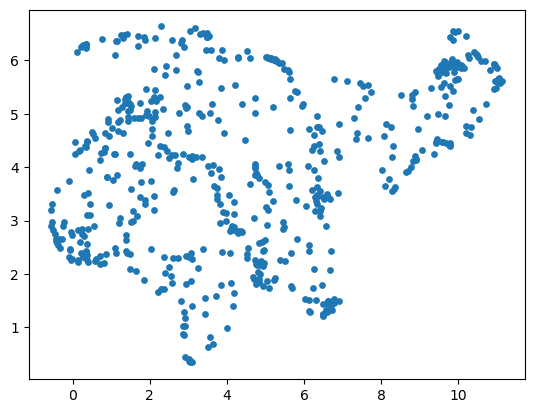

In [44]:
plt.figure()
plt.scatter(v.umap_all[:, 0], v.umap_all[:, 1], s=15)

In [45]:
v.results = t.coll.aggregate([{
    "$vectorSearch": {
        "queryVector": t.emb_model.encode(v.question).tolist(),
        "path": "embedding",
        "numCandidates": 200,
        "limit": 8,
        "index": f"{t.coll.name}_vector_index"
    }}]) 
v.results = list(v.results)

In [46]:
len(v.results)

8

In [47]:
v.umap_query = umap_embeddings([
    t.emb_model.encode(v.question)
], v.umap_transform)

100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


In [48]:
v.umap_query

array([[2.50955939, 2.24930382]])

In [49]:
v.umap_results = umap_embeddings(
    [d['embedding'] for d in v.results],
    v.umap_transform
)

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


In [50]:
v.umap_results.shape

(8, 2)

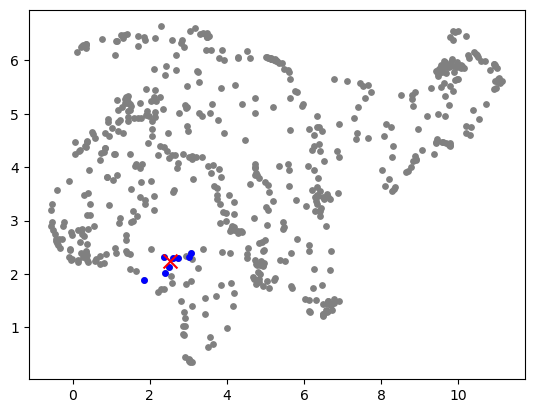

In [51]:
plt.figure()
plt.scatter(v.umap_all[:, 0], v.umap_all[:, 1], s=15, color="gray")
plt.scatter(v.umap_results[:, 0], v.umap_results[:, 1], s=15, color="blue")
plt.scatter(v.umap_query[:, 0], v.umap_query[:, 1], marker="x", s=100, color="r")

## Pitfalls

Vector search always returns results!

In [52]:
%%time
ask_with_rag("What team is Tom Brady playing for in 2024?")

  Based on the information provided in the financial report, there is no mention of Tom Brady or any sports teams. The information only relates to MongoDB, Inc.'s financial statements and related notes. Therefore, I cannot answer your question about Tom Brady's team for 2024.CPU times: user 2.34 s, sys: 407 ms, total: 2.74 s
Wall time: 2.87 s


In [53]:
def query_and_plot_embeddings(coll, question, index_name, emb_model, umap_transform, umap_all):
    t = None
    v = None
    results = coll.aggregate([{
    "$vectorSearch": {
        "queryVector": emb_model.encode(question).tolist(),
        "path": "embedding",
        "numCandidates": 200,
        "limit": 8,
        "index": index_name
    }}]) 
    results = list(results)
    umap_query = umap_embeddings(
        [emb_model.encode(question)], 
        umap_transform)
    umap_results = umap_embeddings(
        [d['embedding'] for d in results],
        umap_transform)
    plt.figure()
    plt.scatter(umap_all[:, 0], umap_all[:, 1], s=15, color="gray")
    plt.scatter(umap_results[:, 0], umap_results[:, 1], s=15, color="blue")
    plt.scatter(umap_query[:, 0], umap_query[:, 1], marker="x", s=100, color="r")

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


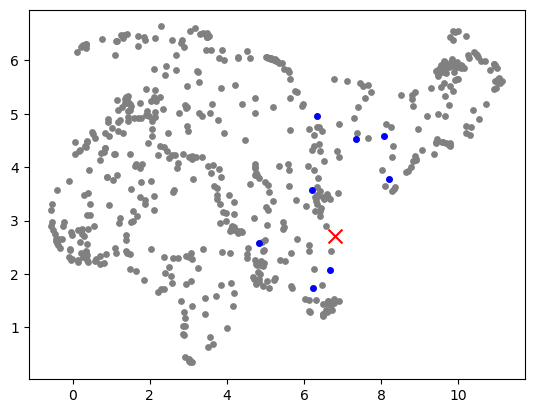

In [54]:
query_and_plot_embeddings(
    t.coll,
    "What team is Tom Brady playing for in 2024?",
    f"{t.coll.name}_vector_index",
    t.emb_model,
    v.umap_transform,
    v.umap_all
)

## LangChain

We'll use LangChain to tie this all together into a simple API.

In [55]:
# https://python.langchain.com/docs/integrations/vectorstores/mongodb_atlas

from langchain.chains import RetrievalQA
from langchain_community.vectorstores import MongoDBAtlasVectorSearch
from langchain_community.embeddings import HuggingFaceEmbeddings

In [56]:
l = Object()
l.llm = t.llm

In [57]:
l.lang_emb = HuggingFaceEmbeddings(model_name="multi-qa-mpnet-base-cos-v1")

Check that the embeddings model returns embeddings of the correct size of 768:

In [58]:
len(l.lang_emb.embed_documents(['This is a test document'])[0])

768

In [59]:
l.vector_search = MongoDBAtlasVectorSearch(
    t.coll, 
    l.lang_emb, 
    index_name="mdb_vector_index",
    embedding_key="embedding")

In [60]:
l.results = list(l.vector_search.max_marginal_relevance_search(
    query="What was the total revenue?",
    k = 8,
))

In [61]:
len(l.results)

8

### Make a Retriever Object

In [62]:
l.retriever = l.vector_search.as_retriever(search_kwargs={"k": 8})

### Make the end-to-end chain object

In [63]:
l.qa = RetrievalQA.from_chain_type(
    llm=l.llm, 
    retriever=l.retriever)

### Query LLM with LangChain

In [64]:
%%time
l.qa.invoke("What was the total revenue?")

 Based on the information provided, the total revenue for the year ended January 31, 2023 was $1,284.0 million.CPU times: user 2.18 s, sys: 622 ms, total: 2.81 s
Wall time: 2.72 s


{'query': 'What was the total revenue?',
 'result': ' Based on the information provided, the total revenue for the year ended January 31, 2023 was $1,284.0 million.'}

In [65]:
%%time
l.qa.invoke("What time period does the report cover?")

 The report covers the fiscal year ended January 31, 2023.CPU times: user 1.2 s, sys: 296 ms, total: 1.5 s
Wall time: 1.74 s


{'query': 'What time period does the report cover?',
 'result': ' The report covers the fiscal year ended January 31, 2023.'}